In [1]:
import os
from os.path import join as join
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from umap import UMAP

from scipy.stats import pearsonr
from scipy.stats import bootstrap
from statsmodels.stats.weightstats import ztest

import numpy as np
import pandas as pd
import shap

import config_local as cl
import ShapCalc

In [5]:
sns.set_theme()
# sns.set(rc={'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)})
plt.rcParams['figure.figsize'] = [10, 10]

# Load

In [17]:
risk_dir = cl.PREDICTION_RISK_SCORE_PATH
ag = cl.names_dict['ag']
smag = cl.names_dict['smag']
agb = cl.names_dict['agb']
smagb = cl.names_dict['smagb']
sm = cl.names_dict['sm']
lasso_str = 'lasso'
tree_str = 'tree'
net_str = 'elastic_net'
ag_pred_path = cl.postfix_path(risk_dir, ag)
smag_pred_path = cl.postfix_path(risk_dir, smag)
agb_pred_path = cl.postfix_path(risk_dir, agb)
smagb_pred_path = cl.postfix_path(risk_dir, smagb)
sm_pred_path = cl.postfix_path(risk_dir, sm)

ag_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH, ag)
smag_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH, smag)
smagb_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH, smagb)
agb_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH, agb)

ag_smag_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH,f'{ag}_VS_{smag}')
agb_smagb_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH,f'{agb}_VS_{smagb}')

In [18]:
smagb_tree_metrics = cl.load_from_subfolders(
    base_path=smagb_pred_path, path_in_folder=join('**', tree_str), file_name='metrics.pickle')
smagb_lasso_metrics = cl.load_from_subfolders(
    base_path=smagb_pred_path, path_in_folder=join('**', lasso_str), file_name='metrics.pickle')
smagb_net_metrics = cl.load_from_subfolders(
    base_path=smagb_pred_path, path_in_folder=join('**', net_str), file_name='metrics.pickle')
agb_tree_metrics = cl.load_from_subfolders(
    base_path=agb_pred_path, path_in_folder=join('**', tree_str), file_name='metrics.pickle')
agb_lasso_metrics = cl.load_from_subfolders(
    base_path=agb_pred_path, path_in_folder=join('**', lasso_str), file_name='metrics.pickle')
agb_net_metrics = cl.load_from_subfolders(
    base_path=agb_pred_path, path_in_folder=join('**', net_str), file_name='metrics.pickle')

In [28]:
tmp_net = cl.load_pickle(join(smagb_pred_path, 'AHI', '0', net_str, 'model.pickle'))
tmp_net.l1_ratio_

1.0

In [31]:
# smagb_net_model = cl.load_from_subfolders(
#     base_path=smagb_pred_path, path_in_folder=join('**', net_str), file_name='model.pickle')
n_iter = 100
prediction_dir = smagb_pred_path
l1_ratios = pd.Series()

for rs in cl.risk_factors:
    base_path = join(prediction_dir, rs)

    for iter in range(n_iter):
        iter_path = join(base_path, str(iter))

        # x_n_train = cl.load_pickle(join(iter_path, 'x_train_normalizes.pickle'))
        # x_n_test = cl.load_pickle(join(iter_path, 'x_test_normalizes.pickle'))
        # x = pd.concat([x_n_train, x_n_test], axis=0)
        model_names = [net_str]

        for model_name in model_names:
            model_path = join(iter_path, model_name)
            model = cl.load_pickle(join(model_path, 'model.pickle'))
            l1_ratio = pd.Series(model.l1_ratio_, index=[rs])
            l1_ratios = pd.concat([l1_ratios, l1_ratio])

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [41]:
l1_ratios[l1_ratios==0.1].index.value_counts()

bt__triglycerides               100
bt__total_cholesterol            72
bt__hba1c                        65
TotalSleepTime                   31
smoke_tobacco_now                13
bt__albumin                      12
q_box_mean_pa_s_vi_plus_mean      4
dtype: int64

In [19]:
metrics = pd.concat([smagb_tree_metrics, smagb_lasso_metrics, smagb_net_metrics, agb_tree_metrics, agb_lasso_metrics, agb_net_metrics], axis=0, keys=['smagb_tree', 'smagb_lasso', 'smagb_net', 'agb_tree', 'agb_lasso', 'agb_net'])
metrics['model'] = metrics.index.get_level_values(0)
metrics = metrics.droplevel(level=0)
metrics

,Coefficient_of_determination,explained_variance_score,pearson_r,pearson_p_value,spearman_r,spearman_p_value,prevalence,AUC,Precision_Recall,model
visceral_fat_volume,0.716010,0.718484,0.853192,1.591596e-238,0.860424,5.424172e-247,NaN,NaN,NaN,smagb_tree
visceral_fat_volume,0.714101,0.714364,0.845379,1.324736e-226,0.852300,3.935720e-234,NaN,NaN,NaN,smagb_tree
visceral_fat_volume,0.717861,0.718140,0.848602,9.103340e-235,0.849261,1.684358e-235,NaN,NaN,NaN,smagb_tree
visceral_fat_volume,0.707418,0.707704,0.841294,8.064051e-230,0.842366,5.746774e-231,NaN,NaN,NaN,smagb_tree
visceral_fat_volume,0.731936,0.732110,0.860860,2.420849e-246,0.861205,9.303559e-247,NaN,NaN,NaN,smagb_tree
...,...,...,...,...,...,...,...,...,...,...
smoke_tobacco_now,NaN,NaN,NaN,NaN,NaN,NaN,0.151542,0.603012,0.191498,agb_net
smoke_tobacco_now,NaN,NaN,NaN,NaN,NaN,NaN,0.144395,0.575739,0.187530,agb_net
smoke_tobacco_now,NaN,NaN,NaN,NaN,NaN,NaN,0.156757,0.594533,0.192062,agb_net
smoke_tobacco_now,NaN,NaN,NaN,NaN,NaN,NaN,0.148347,0.600823,0.190730,agb_net


# Metrics Plot

<AxesSubplot:xlabel='Coefficient_of_determination'>

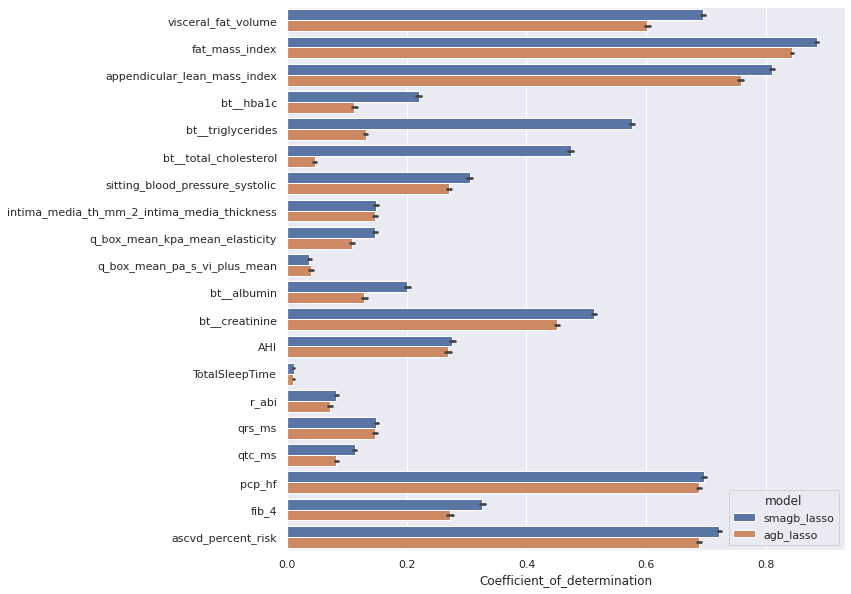

In [20]:
metrics_lasso = pd.concat([smagb_lasso_metrics, agb_lasso_metrics], axis=0, keys=['smagb_lasso', 'agb_lasso'])
metrics_lasso['model'] = metrics_lasso.index.get_level_values(0)
metrics_lasso = metrics_lasso.droplevel(level=0)
sns.barplot(data=metrics_lasso.drop('smoke_tobacco_now'), x='Coefficient_of_determination', y=metrics_lasso.drop('smoke_tobacco_now').index, hue='model')
plt.savefig(join(agb_smagb_plot_path, 'r_2_lasso_barplot.png'), bbox_inches='tight')


<AxesSubplot:xlabel='pearson_r'>

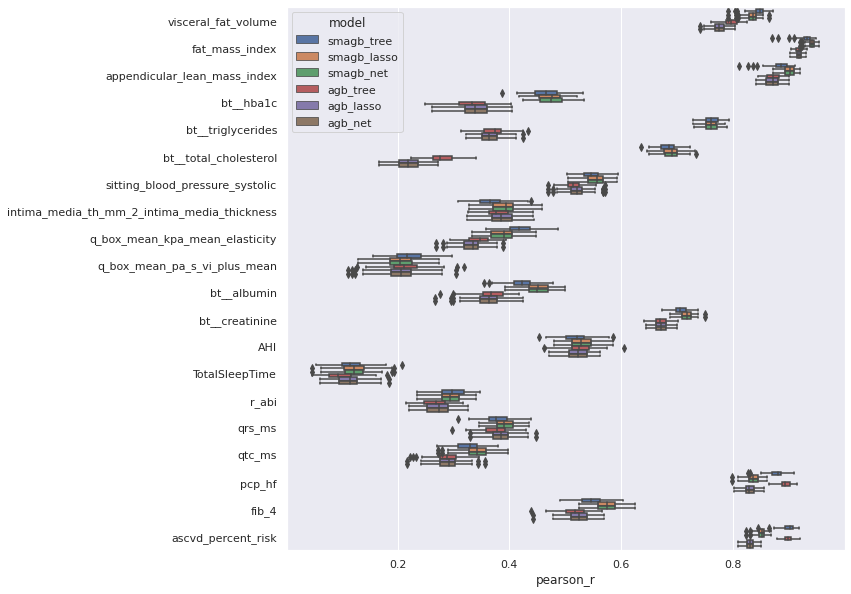

In [21]:
sns.boxplot(data = metrics.drop('smoke_tobacco_now'), x='pearson_r', y=metrics.drop('smoke_tobacco_now').index, hue='model')
# plt.savefig(join(agb_smagb_plot_path, 'pearson_r_boxplot.png'), bbox_inches='tight')

<AxesSubplot:xlabel='pearson_r'>

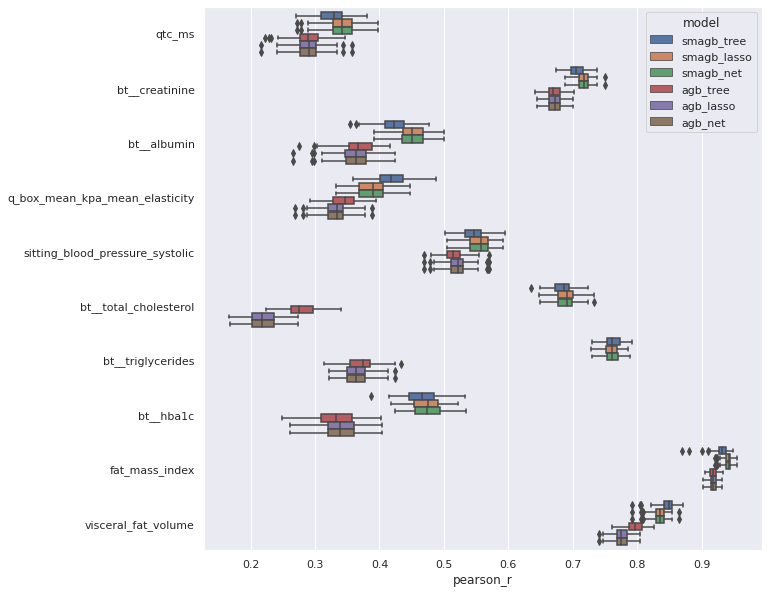

In [22]:
risks_significant = ['qtc_ms', 'bt__creatinine', 'bt__albumin', 'q_box_mean_kpa_mean_elasticity', 'sitting_blood_pressure_systolic', 'bt__total_cholesterol', 'bt__triglycerides', 'bt__hba1c', 'fat_mass_index', 'visceral_fat_volume']
sns.boxplot(data = metrics.loc[risks_significant], x='pearson_r', y=metrics.loc[risks_significant].index, hue='model')

In [42]:
def load_from_subfolders(base_path: os.path, path_in_folder: os.path, file_name: str,
                         list_of_folder: list = cl.risk_factors):
    df = pd.DataFrame()
    for folder in list_of_folder:
        tmp_path = join(base_path, folder)
        for file in glob.glob(join(tmp_path, path_in_folder, file_name)):
            df = pd.concat([df, pd.DataFrame(cl.load_pickle(file))], axis=1)

    return df


def average_over_all_iter_models(df):
    import numbers
    return df.groupby(by=df.columns, axis=1).apply(
        lambda g: g.mean(axis=1) if isinstance(g.iloc[0, 0], numbers.Number) else g.iloc[:, 0])



In [44]:
shap_imp_smagb_tree = load_from_subfolders(base_path=smagb_pred_path, path_in_folder=join('full_train', tree_str, 'shap'), file_name='5_important_features.pickle')
shap_imp_smagb_lasso = load_from_subfolders(base_path=smagb_pred_path, path_in_folder=join('full_train', lasso_str, 'shap'), file_name='5_important_features.pickle')
shap_imp_smagb_net = load_from_subfolders(base_path=smagb_pred_path, path_in_folder=join('full_train', net_str, 'shap'), file_name='5_important_features.pickle')

Text(0.5, 0, '# of risk factors')

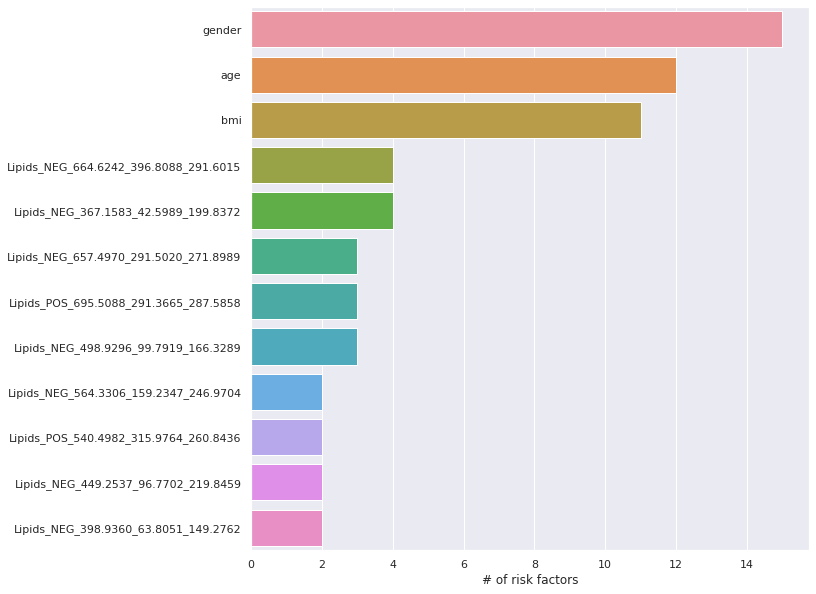

In [51]:
freq_shap_full = shap_imp_smagb_tree.count(axis=1)
freq_shap_full = freq_shap_full[freq_shap_full>1].sort_values(ascending=False)
sns.barplot(x=freq_shap_full, y=freq_shap_full.index)
plt.xlabel('# of risk factors')